<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/autoencoder/linear_autoencoder_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import torch
import torchvision

import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available!")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available!


In [3]:
# set up the general configeration
def set_all_seeds(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

random_seed = 125
set_all_seeds(random_seed)

### Load and visualize the dataset

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# load dataset from torchvision.datasets module
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# print out some data stats

print("Number of training images: ", len(train_data))
print("Number of test images: ", len(test_data))

for inputs, _ in train_loader:
  print("Image batch dimension: ", inputs.shape)
  break

Number of training images:  60000
Number of test images:  10000
Image batch dimension:  torch.Size([20, 1, 28, 28])


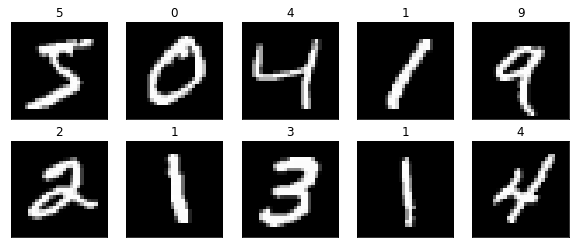

In [10]:
# visualize a batch of training data
def imshow(img):
  plt.imshow(np.squeeze(img), cmap="gray")

# obtain one batch of training images
dataiter = iter(train_loader)
inputs, targets = dataiter.next()
inputs = inputs.numpy()

# plot some images
fig = plt.figure(figsize=(10,4))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  imshow(inputs[idx])
  ax.set_title(str(targets[idx].item()))

### Define a linear autoencoder

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
  def __init__(self, encoding_dim):
    super(AutoEncoder, self).__init__()

    # ----- encoder -------
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128, encoding_dim)

    # ---- decoder -------
    self.fc3 = nn.Linear(encoding_dim, 128)
    self.fc4 = nn.Linear(128, 28*28)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.sigmoid(self.fc4(x))
    return x

encoding_dim = 32
model = AutoEncoder(encoding_dim)
# move model to the right device
model.to(device)
print(model)

AutoEncoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
)


### Define a Loss function and optimizer

In [18]:
import torch.optim as optim

# specify loss function
criterion = nn.MSELoss()

# specify optimizer
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001)

### Train the model

In [20]:
# num of epochs to train the model
num_epochs = 20

# track training loss
train_losses = []

for epoch in range(num_epochs):
  # running train loss
  running_train_loss = 0.0

  for data in train_loader:
    # get the inputs; data is a list of [inputs, targets]
    inputs, _ = data
    # flatten inputs
    inputs = inputs.view(inputs.size(0), -1)
    # move tensor to the right device
    inputs = inputs.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, inputs)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item() * inputs.size(0)

  # calculate avg loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)

  train_losses.append(running_train_loss)

  print("Epoch: {} \tTraining loss: {:.6f}".format(epoch+1, running_train_loss))

print("Finished training!")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training loss: 0.182893
Epoch: 2 	Training loss: 0.176219
Epoch: 3 	Training loss: 0.171105
Epoch: 4 	Training loss: 0.167142
Epoch: 5 	Training loss: 0.164061
Epoch: 6 	Training loss: 0.161563
Epoch: 7 	Training loss: 0.159447
Epoch: 8 	Training loss: 0.157500
Epoch: 9 	Training loss: 0.155884
Epoch: 10 	Training loss: 0.154444
Epoch: 11 	Training loss: 0.153132
Epoch: 12 	Training loss: 0.151958
Epoch: 13 	Training loss: 0.150871
Epoch: 14 	Training loss: 0.149910
Epoch: 15 	Training loss: 0.149019
Epoch: 16 	Training loss: 0.148120
Epoch: 17 	Training loss: 0.147292
Epoch: 18 	Training loss: 0.146495
Epoch: 19 	Training loss: 0.145724
Epoch: 20 	Training loss: 0.144979
Finished training!


### Evaluate the performance of the trained model on the test dataset